# Combinatorial library vs. ChEMBL

<div class="alert alert-block alert-info">
Note that results in this notebook may differ from the numbers shown in the publication because of new data added to ChEMBL and KLIFS.
</div>

## Aims of this notebook

In this notebook we want to compare the combinatorial library to the ChEMBL 33 dataset:

1. How similar are recombined ligands to ChEMBL ligands?
2. Which recombined ligands have exact matches in ChEMBL?

**Note** that the combinatorial library is stored as `json` file (11 M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here. In order to run this notebook, download data from zenodo as instructed in `../../data/combinatorial_library/README.md`.

## Table of contents

1. Most similar ChEMBL ligands  
  1.1. Similarity distribution  
  1.2. Highly similar / identical ligands  
2. Exact matches  
  2.1. Get exact matches  
  2.2. Get ChEMBL clients and set up filtering documentation  
  2.3. Get molecules from ChEMBL (by InChI key)  
  2.4. Get molecules with human targets in ChEMBL  
  2.5. Check molecule/target/assay/bioactivity distributions  
  2.6. Get active molecules (among the exact matches)  
  2.7. Get target metadata (PTC) for active molecules  
  2.8. Results  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chembl_webresource_client.new_client import new_client
from IPython.core.display import HTML
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, PandasTools, rdFingerprintGenerator

from kinfraglib import utils

In [3]:
ACTIVITY_THRESHOLD = 500

In [4]:
HERE = Path(_dh[-1])

## Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(HERE / '../../data/fragment_library_reduced/')
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

## Load ChEMBL molecules

In [6]:
chembl = pd.read_csv(HERE / '../../data/combinatorial_library/chembl_standardized_inchi.csv')
chembl.shape
# NBVAL_CHECK_OUTPUT

(2747263, 2)

## 1. Most similar ChEMBL ligands

In [7]:
chembl_most_similar = pd.read_json(HERE / '../../data/combinatorial_library/chembl_most_similar.json')
chembl_most_similar.head()

,chembl_id,similarity
0,CHEMBL1643262,0.52
1,CHEMBL4930052,0.57
2,CHEMBL5829729,0.50
3,CHEMBL332605,0.64
4,CHEMBL5414397,0.56


### 1.1. Similarity distribution  

In [8]:
chembl_most_similar.similarity.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
# NBVAL_CHECK_OUTPUT

count    1.131460e+07
mean     5.505986e-01
std      7.159571e-02
min      2.500000e-01
1%       4.100000e-01
10%      4.700000e-01
25%      5.000000e-01
50%      5.400000e-01
75%      5.900000e-01
90%      6.400000e-01
99%      7.600000e-01
max      1.000000e+00
Name: similarity, dtype: float64

In [9]:
print(f'Number of ligands without ChEMBL similarity: {chembl_most_similar[chembl_most_similar.similarity.isna()].shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of ligands without ChEMBL similarity: 12872


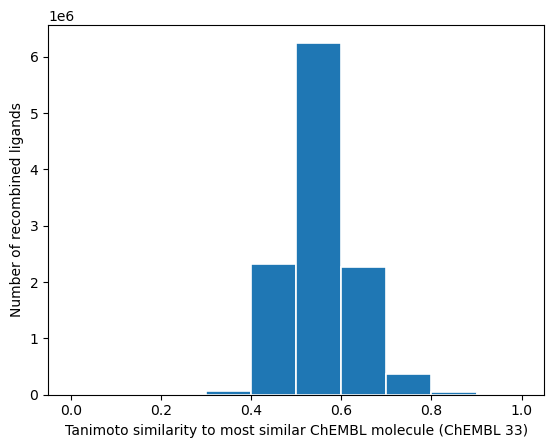

In [10]:
ax = chembl_most_similar.similarity.plot(
    kind='hist', 
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2
)
ax.set_xlabel('Tanimoto similarity to most similar ChEMBL molecule (ChEMBL 33)')
ax.set_ylabel('Number of recombined ligands')
plt.show()

In [11]:
ax.get_figure().savefig('figures/combinatorial_library_most_similar_chembl_molecules.pdf', bbox_inches='tight')

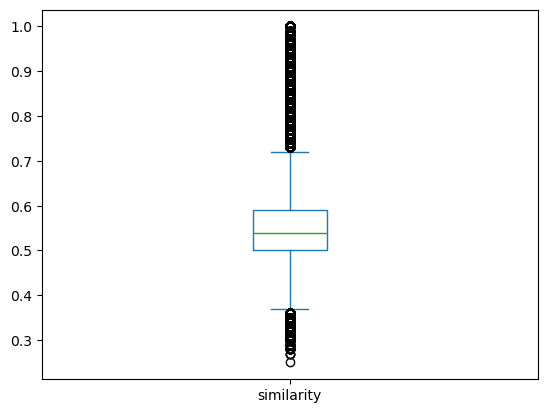

In [12]:
chembl_most_similar.similarity.plot(kind='box')
plt.show()

### 1.2. Highly similar / identical ligands

How many ligands have highly similar fingerprints in ChEMBL vs. combinatorial library? 

**Note** that values of 1.0 do not automatically mean that these ligands are identical: (i) Chemically different ligands can have the same fingerprint and (ii) similarities have been rounded to two decimals (hence high similarities can be rounded to 1.0)

In [13]:
print(f'Number of ligands with similarity of 1.0 to at least one ChEMBL molecule:')
chembl_most_similar[chembl_most_similar.similarity == 1.0].shape[0]
# NBVAL_CHECK_OUTPUT

Number of ligands with similarity of 1.0 to at least one ChEMBL molecule:


468

In [14]:
print(f'Number of ligands with similarity of more than 0.9 to at least one ChEMBL molecule:')
chembl_most_similar[chembl_most_similar.similarity > 0.9].shape[0]
# NBVAL_CHECK_OUTPUT

Number of ligands with similarity of more than 0.9 to at least one ChEMBL molecule:


3783

## 2. Exact matches

Exact matches between the combinatorial library and the ChEMBL molecules are assessed by comparing standardized InChI strings.

### 2.1. Get exact matches

In [15]:
exact_matches = pd.read_json(HERE / '../../data/combinatorial_library/chembl_exact.json')

In [16]:
print(exact_matches.shape[0])
# NBVAL_CHECK_OUTPUT

385


In [17]:
exact_matches.head()

,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
0,"[[AP_12, GA_3], [FP_6, AP_10], [SE_7, AP_11]]","[AP_12, FP_54, GA_12, SE_24]",1,1,1,1,26,1,"[CHEMBL4636757, 1.0]",0,0,InChI=1S/C20H27N5O/c1-4-16(13-26)23-18-10-19(2...
1,"[[AP_12, GA_4], [SE_7, AP_11], [FP_6, AP_10]]","[AP_12, GA_39, SE_26, FP_121]",1,1,1,1,27,1,"[CHEMBL399087, 1.0]",0,0,"InChI=1S/C19H14F3N5/c20-19(21,22)15-12-25-27-1..."
2,"[[SE_7, AP_11], [AP_12, GA_7], [FP_6, AP_10]]","[AP_12, GA_54, FP_121, SE_26]",1,1,1,0,29,1,"[CHEMBL248744, 1.0]",0,0,InChI=1S/C24H19N5/c1-3-9-19(10-4-1)21-17-27-29...
3,"[[AP_12, GA_3], [FP_6, AP_10], [SE_7, AP_11]]","[AP_12, FP_121, SE_26, GA_12]",1,1,1,1,26,1,"[CHEMBL399234, 1.0]",0,0,InChI=1S/C21H21N5/c1-15(2)18-14-24-26-20(23-13...
4,"[[AP_5, FP_10]]","[FP_25, AP_63]",1,1,1,1,15,1,"[CHEMBL2022868, 1.0]",0,1,InChI=1S/C12H9N3/c1-2-4-12-11(3-1)10(5-6-13-12...


In [18]:
exact_matches.drop_duplicates('inchi', inplace=True)
exact_matches.shape[0]
# NBVAL_CHECK_OUTPUT

385

### 2.2. Remove original ligands (exact and substructure matches)

In [19]:
original_ligand_matches = pd.concat(
    [
        pd.read_json(HERE / '../../data/combinatorial_library/original_exact.json'),
        pd.read_json(HERE / '../../data/combinatorial_library/original_substructure.json')
    ]
)
original_ligand_matches.shape
# NBVAL_CHECK_OUTPUT

(444, 12)

In [20]:
exact_matches = exact_matches[
    ~exact_matches.apply(lambda x: x.inchi in original_ligand_matches.inchi.to_list(), axis=1)
]

In [21]:
print(f'Number of exact ChEMBL matches without original ligands: {exact_matches.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of exact ChEMBL matches without original ligands: 286


### 2.2. Get ChEMBL clients and set up filtering documentation

In [22]:
similarity_client = new_client.similarity
molecule_client = new_client.molecule
activity_client = new_client.activity
target_client = new_client.target
drug_client = new_client.drug_indication

In [23]:
def add_filtering_step(filtering, df, step_name):
    return pd.concat([filtering, pd.DataFrame(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'activities']
        ).transpose()],
        axis=0
    )

In [24]:
# Initialize filtering table
filtering = pd.DataFrame(columns=['filtering_step', 'molecules', 'targets', 'assays', 'activities'])

### 2.3. Get molecules from ChEMBL (by InChI key)

- Get molecule data from ChEMBL
- Approved molecules?
- ATC classified molecules?

#### Get molecule data from ChEMBL

In [25]:
# Get InChI keys (will be queries for ChEMBL)
exact_matches['inchi_key'] = exact_matches.inchi.apply(lambda x: Chem.InchiToInchiKey(x))

In [26]:
def get_indication(chembl_id): 
    efo = drug_client.filter(molecule_chembl_id=chembl_id).only("efo_term")
    efo_list = []
    if efo is not None: 
        for e in efo: 
            efo_list.append(e["efo_term"])
    return efo_list 

In [27]:
def get_molecules(inchi_keys):

    result = [molecule_client.get(inchi_key) for inchi_key in inchi_keys]
    molecules = pd.DataFrame(result)
    molecules = molecules[['molecule_chembl_id', 'molecule_structures', 'first_approval', 'atc_classifications', 'pref_name']]
    molecules['efo_class'] = [get_indication(mol) for mol in list(molecules["molecule_chembl_id"])]
    molecules['smiles'] = molecules.molecule_structures.apply(lambda x: x['canonical_smiles'])
    molecules['inchi'] = molecules.molecule_structures.apply(lambda x: x['standard_inchi'])
    molecules.drop('molecule_structures', axis=1, inplace=True)
    PandasTools.AddMoleculeColumnToFrame(molecules, 'smiles')

    print(f'Number of queries: {len(inchi_keys)}')
    print(f'Number of query results: {molecules.shape[0]}')
    
    return molecules

In [28]:
molecules = get_molecules(exact_matches.inchi_key)
# NBVAL_CHECK_OUTPUT

Number of queries: 286
Number of query results: 286


#### Approved molecules?
> Note: Since the fragment library has been updated, other fragments might be selected for the reduced fragment library used to create the combinatorial library. Hence the combinatorial library slightly differ from the publication. 

,molecule_chembl_id,first_approval,atc_classifications,pref_name,efo_class,smiles,inchi,ROMol
186,CHEMBL64,1952.0,"[J04AC51, J04AC01]",ISONIAZID,"[pulmonary tuberculosis, diabetic foot, HIV in...",NNC(=O)c1ccncc1,InChI=1S/C6H7N3O/c7-9-6(10)5-1-3-8-4-2-5/h1-4H...,

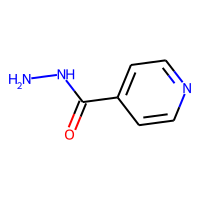

In [29]:
# Check if first_approval field is not empty
HTML(molecules[~molecules.first_approval.isna()].to_html(notebook=True))

**`CHEMBL64`, Isoniazid**

- [ChEMBL compound report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL64/)
- [Drugbank](https://www.drugbank.ca/drugs/DB00951)
  > **Description**: Antibacterial agent used primarily as a tuberculostatic. It remains the treatment of choice for tuberculosis. </br>
  > **Mechanism of action**: Isoniazid is a prodrug and must be activated by bacterial catalase. Specifically, activation is associated with reduction of the mycobacterial ferric **KatG catalase-peroxidase** by hydrazine and reaction with oxygen to form an oxyferrous enzyme complex. Once activated, isoniazid inhibits the synthesis of mycoloic acids, an essential component of the bacterial cell wall. At therapeutic levels isoniazid is bacteriocidal against actively growing intracellular and extracellular *Mycobacterium tuberculosis* organisms. Specifically isoniazid inhibits **InhA, the enoyl reductase** from *Mycobacterium tuberculosis*, by forming a covalent adduct with the NAD cofactor. It is the INH-NAD adduct that acts as a slow, tight-binding competitive inhibitor of InhA. </br>
  > **Target**: Catalase-peroxidase (UniProt ID [P9WIE5](https://www.uniprot.org/uniprot/P9WIE5))
  
- Off-targets? Kinases?
  - Cytochrome P450 2E1 and Arylamine N-acetyltranserases are associated with isoniazid side effects ([DrugBank's "Pharmacogenomic Effects/ADRs"](https://www.drugbank.ca/drugs/DB00951)).
  - [SwissTargetPredictions](http://swisstargetprediction.ch/result.php?job=1698711713&organism=Homo_sapiens) (ligand-based target prediction) predicts a few kinases in the top 15 off-targets.
  - [ProBis](http://probis.cmm.ki.si/browse.php?job_id=2cca.A) (structure-based target prediction for [2CCA](https://www.rcsb.org/structure/2cca)) predicts mainly peroxidases (no kinases).

#### ATC classified molecules?

> In the Anatomical Therapeutic Chemical (ATC) classification system, the active substances are divided into different groups according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties.
Drugs are classified in groups at five different levels.

https://www.who.int/medicines/regulation/medicines-safety/toolkit_atc/en/

In [30]:
# Check if atc classified field is not empty
molecules[molecules.atc_classifications.str.len() != 0].drop('ROMol', axis=1)

,molecule_chembl_id,first_approval,atc_classifications,pref_name,efo_class,smiles,inchi
186,CHEMBL64,1952.0,"[J04AC51, J04AC01]",ISONIAZID,"[pulmonary tuberculosis, diabetic foot, HIV in...",NNC(=O)c1ccncc1,InChI=1S/C6H7N3O/c7-9-6(10)5-1-3-8-4-2-5/h1-4H...


Same as retrieved via the approved molecules query.

### 2.4. Get molecules with human targets in ChEMBL

- Get activities (by molecule ChEMBL IDs)
- Remove activities for non-human target organisms

#### Get activities (by molecule ChEMBL IDs)

In [31]:
def get_activities(molecule_ids):
    
    activities = activity_client.filter(
        molecule_chembl_id__in=molecule_ids,
        type='IC50', 
        relation='=', 
        assay_type='B'
    ).only(
        'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
        'molecule_chembl_id', 'type', 'standard_units', 'relation', 'standard_value', \
        'target_chembl_id', 'target_organism', 'target_pref_name'
    )
    
    activities_df = pd.DataFrame.from_records(list(activities))
    activities_df = activities_df.astype({'standard_value': 'float'})
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {activities_df.shape[0]}')
    
    return activities_df

In [32]:
activities = get_activities(list(molecules.molecule_chembl_id))
# NBVAL_CHECK_OUTPUT

Number of queries: 286
Number of query results: 347


In [33]:
activities.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name', 'type',
       'units', 'value'],
      dtype='object')

In [34]:
filtering = add_filtering_step(filtering, activities, 'ChEMBL bioactivity entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347


**Important**: Check if all standard units are really nM.

In [35]:
activities.groupby(
    ['standard_units']
).size()
# NBVAL_CHECK_OUTPUT

standard_units
%            1
nM         345
ug.mL-1      1
dtype: int64

In [36]:
# Just to be sure, drop all entries with standard unit other than nM 
# Note: One could also perform a unit conversion here
activities.drop(
    index=activities[activities.standard_units != 'nM'].index,
    inplace=True
)

In [37]:
filtering = add_filtering_step(filtering, activities, 'Remove non-nM activities')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347
0,Remove non-nM activities,134,110,210,345


#### Remove activities for non-human target organisms

In [38]:
activities

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,type,units,value
0,323609,CHEMBL751094,In vitro inhibitory activity against H1N9 stra...,B,CHEMBL71186,=,nM,1500000.0,CHEMBL3046,Homo sapiens,Sialidase-3,IC50,mM,1.5
1,434737,CHEMBL732636,Inhibitory activity against Mitogen-activated ...,B,CHEMBL401695,=,nM,130.0,CHEMBL2094115,Homo sapiens,MAP kinase p38,IC50,nM,130.0
2,434738,CHEMBL765226,Inhibitory activity against recombinant human ...,B,CHEMBL401695,=,nM,90.0,CHEMBL1906,Homo sapiens,RAF proto-oncogene serine/threonine-protein ki...,IC50,nM,90.0
3,445285,CHEMBL734079,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL67658,=,nM,86.0,CHEMBL2094115,Homo sapiens,MAP kinase p38,IC50,nM,86.0
4,445286,CHEMBL820306,Inhibition of c-Jun N-terminal kinase 2-alpha 1,B,CHEMBL67658,=,nM,910.0,CHEMBL4179,Homo sapiens,Mitogen-activated protein kinase 9,IC50,nM,910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,29047733,CHEMBL5739509,ADP-Glo™ Kinase Assay: The ADP-Glo™ Kinase Ass...,B,CHEMBL6033856,=,nM,388.0,CHEMBL1841,Homo sapiens,Tyrosine-protein kinase Fyn,IC50,nM,388.0
343,29047754,CHEMBL5739509,ADP-Glo™ Kinase Assay: The ADP-Glo™ Kinase Ass...,B,CHEMBL5752959,=,nM,1970.0,CHEMBL1841,Homo sapiens,Tyrosine-protein kinase Fyn,IC50,nM,1970.0
344,29047868,CHEMBL5739509,ADP-Glo™ Kinase Assay: The ADP-Glo™ Kinase Ass...,B,CHEMBL5825290,=,nM,987.0,CHEMBL1841,Homo sapiens,Tyrosine-protein kinase Fyn,IC50,nM,987.0
345,29047883,CHEMBL5739509,ADP-Glo™ Kinase Assay: The ADP-Glo™ Kinase Ass...,B,CHEMBL5756667,=,nM,30000.0,CHEMBL1841,Homo sapiens,Tyrosine-protein kinase Fyn,IC50,nM,30000.0


In [39]:
activities.sort_values('target_organism').groupby('target_organism').size().sort_values()
# NBVAL_CHECK_OUTPUT

target_organism
Agaricus bisporus               1
Escherichia coli K-12           1
Mycobacterium tuberculosis      1
Bos taurus                      2
Ovis aries                      2
Photinus pyralis                2
Photuris pennsylvanica          2
Mus musculus                    6
Homo sapiens                  299
dtype: int64

In [40]:
activities = activities[activities.target_organism == 'Homo sapiens'].copy()
activities.drop('target_organism', axis=1, inplace=True)

In [41]:
filtering = add_filtering_step(filtering, activities, 'Only human entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347
0,Remove non-nM activities,134,110,210,345
0,Only human entries,122,97,178,299


### 2.5. Check molecule/target/assay/bioactivity distributions

#### How many targets are reported per molecule?

In [42]:
n_targets_per_molecule = activities.groupby(
    ['molecule_chembl_id']
)['target_chembl_id'].size()

n_targets_per_molecule.value_counts(sort=False).sort_index()
# NBVAL_CHECK_OUTPUT

1     54
2     32
3     13
4     11
5      3
6      3
7      1
8      1
9      1
10     2
21     1
Name: target_chembl_id, dtype: int64

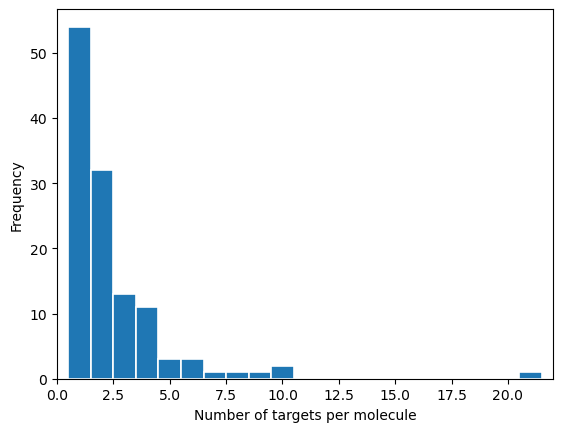

In [43]:
ax = n_targets_per_molecule.plot(
    kind='hist', 
    bins=np.arange(n_targets_per_molecule.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_targets_per_molecule.max() + 1]
)
ax.set_xlabel('Number of targets per molecule')
plt.show()

#### How many different assays were used to measure molecule-target activities?

In [44]:
n_assays_per_molecule_target = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['assay_chembl_id'].size()

n_assays_per_molecule_target.value_counts(sort=False).sort_index()
# NBVAL_CHECK_OUTPUT

1     163
2      39
3       6
4       4
6       1
7       1
11      1
Name: assay_chembl_id, dtype: int64

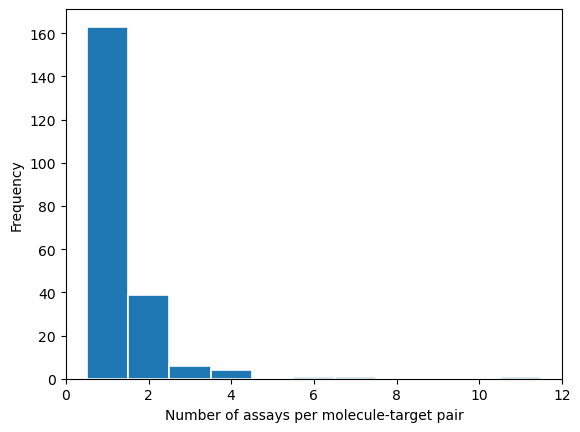

In [45]:
ax = n_assays_per_molecule_target.plot(
    kind='hist', 
    bins=np.arange(n_assays_per_molecule_target.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_assays_per_molecule_target.max() + 1]
)
ax.set_xlabel('Number of assays per molecule-target pair')
plt.show()

#### Look at all activities measured per molecule-target-assay combination

Get all activities for each molecule-target-assay combination.

In [46]:
activities_per_molecule_target_assay = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
)['standard_value'].apply(list).reset_index()

Show examples.

In [47]:
activities_per_molecule_target_assay.head()

,molecule_chembl_id,target_chembl_id,target_pref_name,assay_chembl_id,assay_description,standard_value
0,CHEMBL1080394,CHEMBL2971,Tyrosine-protein kinase JAK2,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,[467.0]
1,CHEMBL1081675,CHEMBL260,Mitogen-activated protein kinase 14,CHEMBL1101788,Inhibition of p38alpha,[150.0]
2,CHEMBL1089986,CHEMBL2185,Aurora kinase B,CHEMBL1110578,Inhibition of aurora B assessed as inhibition ...,[6161.0]
3,CHEMBL1089986,CHEMBL3430907,Aurora kinase B/Inner centromere protein,CHEMBL1110577,Inhibition of human recombinant aurora B/INCEN...,[802.0]
4,CHEMBL1089986,CHEMBL3883304,Aurora kinase A/Targeting protein for Xklp2,CHEMBL1110576,Inhibition of human recombinant aurora A/TPX2 ...,[982.0]


Get all activities for each molecule-target combination.

In [48]:
activities_per_molecule_target = activities_per_molecule_target_assay.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['standard_value'].apply(list).reset_index()

Get molecule-target pairs that have multiple activities from either multiple assays or a single assay.

In [49]:
activities_per_molecule_target[
    (activities_per_molecule_target.standard_value.apply(len) > 1) | (activities_per_molecule_target.standard_value.apply(len)[0] > 1)
].reset_index()

,index,molecule_chembl_id,target_chembl_id,standard_value
0,20,CHEMBL1652738,CHEMBL3629,"[[4.0], [4300.0], [4.0]]"
1,52,CHEMBL2425648,CHEMBL2276,"[[87.0], [86.6]]"
2,53,CHEMBL2425648,CHEMBL4179,"[[250.0], [253.5]]"
3,73,CHEMBL304624,CHEMBL1906,"[[23.0], [23.0]]"
4,82,CHEMBL3128069,CHEMBL4247,"[[0.8], [6.6], [9.0], [4.5], [0.6], [0.2], [3...."
5,89,CHEMBL3128075,CHEMBL4247,"[[176.0], [14.0], [176.0]]"
6,90,CHEMBL3286813,CHEMBL4247,"[[4.6], [54.0]]"
7,92,CHEMBL3341791,CHEMBL4439,"[[21000.0], [4300.0]]"
8,100,CHEMBL3403541,CHEMBL2971,"[[1.0], [1.0]]"
9,105,CHEMBL3409588,CHEMBL4040,"[[3.9], [3.9], [1.1]]"


### 2.6. Get active molecules (among the exact matches)

- Get highest activity (lowest IC50) per molecule-target pair
- Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

#### Get highest activity (lowest IC50) per molecule-target pair

Get lowest IC50 value per molecule-target pair by (i) sorting the DataFrame by molecule ChEMBL ID, target ChEMBL ID and activity value (ascending), (ii) group activites by molecule-target pairs, and (iii) take the first activity value (i.e. the minimum value because of step (ii)) per molecule-target pair (i.e. per group).

In [50]:
activities_min = activities.sort_values(
    ['molecule_chembl_id', 'target_chembl_id', 'standard_value']
).groupby(
    ['molecule_chembl_id', 'target_chembl_id']
).first().reset_index()

In [51]:
filtering = add_filtering_step(filtering, activities_min, 'Get minimum IC50 per molecule-target pair')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347
0,Remove non-nM activities,134,110,210,345
0,Only human entries,122,97,178,299
0,Get minimum IC50 per molecule-target pair,122,97,130,215


#### Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

In [52]:
activities_active = activities_min[activities_min.standard_value <= ACTIVITY_THRESHOLD]
activities_active.head()

,molecule_chembl_id,target_chembl_id,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,standard_value,target_pref_name,type,units,value
0,CHEMBL1080394,CHEMBL2971,3227667,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,B,=,nM,467.0,Tyrosine-protein kinase JAK2,IC50,nM,467.0
1,CHEMBL1081675,CHEMBL260,3223580,CHEMBL1101788,Inhibition of p38alpha,B,=,nM,150.0,Mitogen-activated protein kinase 14,IC50,uM,0.15
9,CHEMBL1269663,CHEMBL279,3521784,CHEMBL1273328,Inhibition of VEGFR2,B,=,nM,107.2,Vascular endothelial growth factor receptor 2,IC50,nM,107.2
10,CHEMBL1287863,CHEMBL4630,3603342,CHEMBL1291622,Inhibition of His-tagged CHK1 after 2 hrs by l...,B,=,nM,2.0,Serine/threonine-protein kinase Chk1,IC50,nM,2.0
11,CHEMBL1287919,CHEMBL4630,3603345,CHEMBL1291622,Inhibition of His-tagged CHK1 after 2 hrs by l...,B,=,nM,5.0,Serine/threonine-protein kinase Chk1,IC50,nM,5.0


In [53]:
filtering = add_filtering_step(filtering, activities_active, 'Only "active" molecule-target pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347
0,Remove non-nM activities,134,110,210,345
0,Only human entries,122,97,178,299
0,Get minimum IC50 per molecule-target pair,122,97,130,215
0,"Only ""active"" molecule-target pairs",82,61,82,138


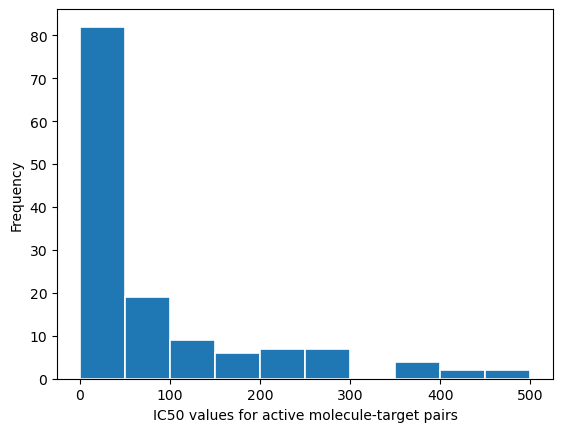

In [54]:
ax = activities_active.standard_value.plot(
    kind='hist', 
    bins=np.arange(0, 501, 50), 
    edgecolor='white', 
    linewidth=1.2
)
ax.set_xlabel('IC50 values for active molecule-target pairs')
plt.show()

### 2.7. Get target metadata (PTC) for active molecules

- Get ChEMBL target details: Protein target classification (PTC)
- Show enzyme group distribution for unique target ChEMBL IDs
- Combine molecule, bioactivity, and target information

#### Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here: https://github.com/chembl/chembl_webservices_2/issues/95

In [55]:
target_chembl_ids = list(activities_active.target_chembl_id.unique())
print(f'Number of unique targets (target ChEMBL IDs): {len(target_chembl_ids)}')
# NBVAL_CHECK_OUTPUT

Number of unique targets (target ChEMBL IDs): 61


Get PTC for target ChEMBL IDs.

In [56]:
# Takes a up to a minute
protein_target_classifications = utils.get_protein_target_classifications(target_chembl_ids)
print(f'Number of PTCs (multiple PTCs per target possible): {protein_target_classifications.shape[0]}') 
# NBVAL_CHECK_OUTPUT

Number of PTCs (multiple PTCs per target possible): 72


In [57]:
protein_target_classifications.head()

,target_chembl_id,protein_class_id,l1,l2,l3,l4,l5,l6,l7,l8,component_id,protein_classification_id
0,CHEMBL2971,152,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,1302,152
1,CHEMBL2971,153,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,1302,153
2,CHEMBL260,332,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase MAPK family,CMGC protein kinase p38 subfamily,None,None,2937,332
3,CHEMBL279,160,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase VEGFR family,None,None,None,359,160
4,CHEMBL4630,411,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase CAMK1 family,CAMK protein kinase CHK1 subfamily,None,None,2947,411


Show targets with multiple PTCs.

In [58]:
n_ptc_per_target = protein_target_classifications.groupby('target_chembl_id').size()
protein_target_classifications[protein_target_classifications.target_chembl_id.isin(n_ptc_per_target[n_ptc_per_target > 1].index)]

,target_chembl_id,protein_class_id,l1,l2,l3,l4,l5,l6,l7,l8,component_id,protein_classification_id
0,CHEMBL2971,152,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,1302,152
1,CHEMBL2971,153,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,1302,153
5,CHEMBL2095191,129,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,699,129
6,CHEMBL2095191,252,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,1946,252
7,CHEMBL2095191,252,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,2389,252
24,CHEMBL2094115,332,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase MAPK family,CMGC protein kinase p38 subfamily,None,None,1269,332
25,CHEMBL2094115,332,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase MAPK family,CMGC protein kinase p38 subfamily,None,None,2280,332
26,CHEMBL2094115,332,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase MAPK family,CMGC protein kinase p38 subfamily,None,None,2937,332
27,CHEMBL2094115,332,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase MAPK family,CMGC protein kinase p38 subfamily,None,None,2992,332
37,CHEMBL2835,152,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,1164,152


Select per target the PTC that has the least `None` values (if the same number of `None`, select first entry).

In [59]:
group_representatives = []

for name, group in protein_target_classifications.groupby('target_chembl_id', sort=False):
    
    if len(group) == 1:
        group_representatives.append(group)
    else:
        ix_least_none = group['l1 l2 l3 l4 l5 l6 l7 l8'.split()].isna().sum(axis=1).idxmin()
        group_representatives.append(group.loc[[ix_least_none]])
        
protein_target_classifications = pd.concat(group_representatives)
print(f'Number of PTCs (after deduplicating PTCs per target): {protein_target_classifications.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of PTCs (after deduplicating PTCs per target): 61


#### Show enzyme group distribution for unique target ChEMBL IDs

In [60]:
protein_target_classifications.sort_values('l2').groupby(by='l2').size().sort_values()
# NBVAL_CHECK_OUTPUT

l2
Nuclear receptor     1
Protease             1
Kinase              59
dtype: int64

#### Combine molecule, bioactivity, and target information

Merge bioactivities and PTC information on target ChEMBL IDs.

In [61]:
activities_active = pd.merge(
    activities_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by=['molecule_chembl_id', 'standard_value']
)[['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'standard_value']]

activities_active.fillna('Unknown', inplace=True)

print(activities_active.shape)
# NBVAL_CHECK_OUTPUT

(138, 12)


In [62]:
activities_active.head()

,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,standard_value
0,CHEMBL1080394,CHEMBL2971,Tyrosine-protein kinase JAK2,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,Unknown,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,467.0
1,CHEMBL1081675,CHEMBL260,Mitogen-activated protein kinase 14,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase MAPK family,CMGC protein kinase p38 subfamily,CHEMBL1101788,Inhibition of p38alpha,150.0
2,CHEMBL1269663,CHEMBL279,Vascular endothelial growth factor receptor 2,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase VEGFR family,Unknown,CHEMBL1273328,Inhibition of VEGFR2,107.2
3,CHEMBL1287863,CHEMBL4630,Serine/threonine-protein kinase Chk1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase CAMK1 family,CAMK protein kinase CHK1 subfamily,CHEMBL1291622,Inhibition of His-tagged CHK1 after 2 hrs by l...,2.0
4,CHEMBL1287919,CHEMBL4630,Serine/threonine-protein kinase Chk1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase CAMK1 family,CAMK protein kinase CHK1 subfamily,CHEMBL1291622,Inhibition of His-tagged CHK1 after 2 hrs by l...,5.0


### 2.8. Results

- Number of targets per molecule
- Targets per molecule
- Molecules without kinase target(s)
- Molecules with kinase target(s)
- Molecules with kinase target(s) with activity of <= 5 nM

`activities_active` contains information for each ChEMBL molecule-target combination.

#### Number of targets per molecule

In [63]:
n_active_targets_per_molecule = activities_active.groupby(['molecule_chembl_id'])['target_chembl_id'].size()

n_active_targets_per_molecule.value_counts(sort=False).sort_index()
# NBVAL_CHECK_OUTPUT

1     62
2     11
3      2
4      2
5      1
8      3
11     1
Name: target_chembl_id, dtype: int64

Text(0.5, 0, 'Number of targets per molecule')

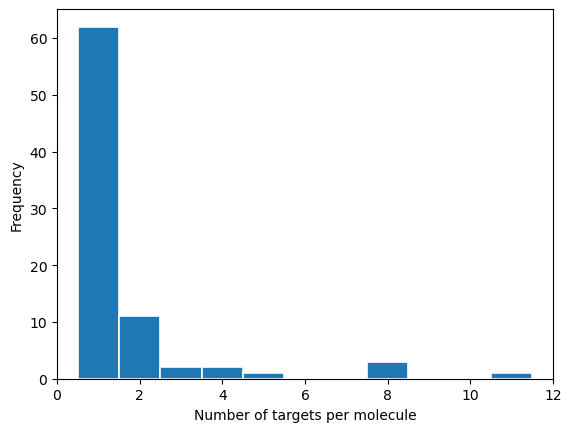

In [64]:
ax = n_active_targets_per_molecule.plot(
    kind='hist', 
    bins=np.arange(n_active_targets_per_molecule.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_active_targets_per_molecule.max() + 1]
)
ax.set_xlabel('Number of targets per molecule')

#### Targets per molecule

In [65]:
pd.set_option("display.max_rows", 100)
pd.set_option('max_colwidth', 200)

In [66]:
molecules_with_targets = pd.DataFrame(
    [
        activities_active.groupby(['molecule_chembl_id'])['l2'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['target_chembl_id'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()

print(f'Number of molecules with human targets that have activity <= {ACTIVITY_THRESHOLD}: {molecules_with_targets.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of molecules with human targets that have activity <= 500: 82


In [67]:
# Add molecule name
molecules_with_targets = pd.merge(
    molecules_with_targets, molecules[['molecule_chembl_id', 'pref_name']], on='molecule_chembl_id', how='left'
)

In [68]:
molecules_with_targets

,molecule_chembl_id,l2,target_pref_name,target_chembl_id,standard_value,pref_name
0,CHEMBL1080394,[Kinase],[Tyrosine-protein kinase JAK2],[CHEMBL2971],[467.0],None
1,CHEMBL1081675,[Kinase],[Mitogen-activated protein kinase 14],[CHEMBL260],[150.0],None
2,CHEMBL1269663,[Kinase],[Vascular endothelial growth factor receptor 2],[CHEMBL279],[107.2],None
3,CHEMBL1287863,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[2.0],None
4,CHEMBL1287919,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[5.0],None
5,CHEMBL1288009,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[3.0],None
6,CHEMBL1288251,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[34.0],None
7,CHEMBL1288278,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[1.0],None
8,CHEMBL1288303,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[4.0],None
9,CHEMBL1652699,[Kinase],[Casein kinase II],[CHEMBL2095191],[27.0],None


#### Molecules without kinase target(s)

In [69]:
molecules_with_targets[~molecules_with_targets.l2.apply(lambda x: 'Kinase' in x)]

,molecule_chembl_id,l2,target_pref_name,target_chembl_id,standard_value,pref_name
36,CHEMBL362507,[Nuclear receptor],[Estrogen receptor beta],[CHEMBL242],[201.0],None
56,CHEMBL4476705,[Protease],[Bifunctional epoxide hydrolase 2],[CHEMBL2409],[260.0],None


#### Molecules with kinase target(s)

Keep only molecule-target pairs where target=kinase.

In [70]:
activities_active_kinases = activities_active[
    activities_active.l2 == 'Kinase'
]

In [71]:
filtering = add_filtering_step(filtering, activities_active_kinases, 'Only molecule-kinase pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347
0,Remove non-nM activities,134,110,210,345
0,Only human entries,122,97,178,299
0,Get minimum IC50 per molecule-target pair,122,97,130,215
0,"Only ""active"" molecule-target pairs",82,61,82,138
0,Only molecule-kinase pairs,80,59,80,136


Across all molecule-target pairs count kinase groups.

In [72]:
activities_active_kinases.l4.apply(lambda x: x.split()[0]).value_counts()

TKL        34
CMGC       33
TK         26
CAMK       17
Other      15
STE         5
Unknown     3
AGC         3
Name: l4, dtype: int64

Summarize target information per molecule (`molecules_with_kinase_targets`).

In [73]:
molecules_with_kinase_targets = pd.DataFrame(
    [
        activities_active_kinases.groupby(['molecule_chembl_id'])['l4'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['target_chembl_id'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()
print(f'Number of molecules with kinase target(s): {molecules_with_kinase_targets.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of molecules with kinase target(s): 80


Show molecules with kinase targets (sorted by the molecules' minimum activity value):

In [74]:
molecules_with_kinase_targets = molecules_with_kinase_targets.loc[molecules_with_kinase_targets.standard_value.apply(min).sort_values().index]
molecules_with_kinase_targets

,l4,target_pref_name,target_chembl_id,standard_value
molecule_chembl_id,,,,
CHEMBL3128069,"[TKL protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase g...","[ALK tyrosine kinase receptor, Tyrosine-protein kinase Fer, Leukocyte tyrosine kinase receptor, BDNF/NT-3 growth factors receptor, Tyrosine-protein kinase Fes/Fps, Tyrosine-protein kinase JAK2, Pr...","[CHEMBL4247, CHEMBL3982, CHEMBL5627, CHEMBL4898, CHEMBL5455, CHEMBL2971, CHEMBL5469, CHEMBL4599, CHEMBL2695, CHEMBL2815, CHEMBL5608]","[0.2, 2.0, 2.0, 4.0, 5.0, 12.0, 12.0, 15.0, 16.0, 17.0, 18.0]"
CHEMBL4085582,[TK protein kinase group],[Tyrosine-protein kinase JAK3],[CHEMBL2148],[0.3]
CHEMBL4475689,[TK protein kinase group],[Receptor-type tyrosine-protein kinase FLT3],[CHEMBL1974],[0.327]
CHEMBL1288278,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[1.0]
CHEMBL3403541,"[TK protein kinase group, TK protein kinase group, TK protein kinase group]","[Tyrosine-protein kinase JAK2, Non-receptor tyrosine-protein kinase TYK2, Tyrosine-protein kinase JAK1]","[CHEMBL2971, CHEMBL3553, CHEMBL2835]","[1.0, 2.0, 3.0]"
CHEMBL3409588,"[CMGC protein kinase group, CMGC protein kinase group, CMGC protein kinase group]","[Mitogen-activated protein kinase 1, Mitogen-activated protein kinase 3, Mitogen-activated protein kinase; ERK1/ERK2]","[CHEMBL4040, CHEMBL3385, CHEMBL1907606]","[1.1, 2.7, 17.0]"
CHEMBL4080944,[CMGC protein kinase group],[Mitogen-activated protein kinase 1],[CHEMBL4040],[1.2]
CHEMBL2385579,"[TKL protein kinase group, TK protein kinase group, TKL protein kinase group, TKL protein kinase group, Unknown, TKL protein kinase group, TKL protein kinase group, TKL protein kinase group]","[TGF-beta receptor type-2, Vascular endothelial growth factor receptor 2, Bone morphogenetic protein receptor type-1A, Bone morphogenetic protein receptor type-2, 5'-AMP-activated protein kinase s...","[CHEMBL4267, CHEMBL279, CHEMBL5275, CHEMBL5467, CHEMBL3847, CHEMBL5311, CHEMBL5903, CHEMBL5476]","[1.37, 1.68, 10.4, 15.9, 39.9, 42.1, 53.4, 60.9]"
CHEMBL4079515,[CMGC protein kinase group],[Mitogen-activated protein kinase 1],[CHEMBL4040],[1.4]


In [75]:
# Add SMILES to molecule-kinase dataset
molecules_with_kinase_targets = pd.merge(
    molecules_with_kinase_targets, molecules[['molecule_chembl_id', 'smiles']], on='molecule_chembl_id', how='left'
)

In [76]:
molecules_with_kinase_targets

,molecule_chembl_id,l4,target_pref_name,target_chembl_id,standard_value,smiles
0,CHEMBL3128069,"[TKL protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase g...","[ALK tyrosine kinase receptor, Tyrosine-protein kinase Fer, Leukocyte tyrosine kinase receptor, BDNF/NT-3 growth factors receptor, Tyrosine-protein kinase Fes/Fps, Tyrosine-protein kinase JAK2, Pr...","[CHEMBL4247, CHEMBL3982, CHEMBL5627, CHEMBL4898, CHEMBL5455, CHEMBL2971, CHEMBL5469, CHEMBL4599, CHEMBL2695, CHEMBL2815, CHEMBL5608]","[0.2, 2.0, 2.0, 4.0, 5.0, 12.0, 12.0, 15.0, 16.0, 17.0, 18.0]",Cc1nc([C@](C)(O)CO)sc1-c1cnc(N)c(O[C@H](C)c2cc(F)ccc2-n2nccn2)c1
1,CHEMBL4085582,[TK protein kinase group],[Tyrosine-protein kinase JAK3],[CHEMBL2148],[0.3],C=CC(=O)Nc1cccc(-c2ncnc3[nH]ccc23)c1
2,CHEMBL4475689,[TK protein kinase group],[Receptor-type tyrosine-protein kinase FLT3],[CHEMBL1974],[0.327],CN1CCN(c2ccc(Nc3cc(-c4cccs4)n[nH]3)cc2)CC1
3,CHEMBL1288278,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[1.0],NC(=O)c1ccc(-c2cc3c(N[C@H]4CCCNC4)ncc(C(N)=O)c3s2)cc1
4,CHEMBL3403541,"[TK protein kinase group, TK protein kinase group, TK protein kinase group]","[Tyrosine-protein kinase JAK2, Non-receptor tyrosine-protein kinase TYK2, Tyrosine-protein kinase JAK1]","[CHEMBL2971, CHEMBL3553, CHEMBL2835]","[1.0, 2.0, 3.0]",Cc1ccc(Cl)cc1-n1cc(-c2ncnc3[nH]ccc23)cc1C(N)=O
5,CHEMBL3409588,"[CMGC protein kinase group, CMGC protein kinase group, CMGC protein kinase group]","[Mitogen-activated protein kinase 1, Mitogen-activated protein kinase 3, Mitogen-activated protein kinase; ERK1/ERK2]","[CHEMBL4040, CHEMBL3385, CHEMBL1907606]","[1.1, 2.7, 17.0]",O=c1cc(-c2ccnc(NC3CCOCC3)n2)ccn1[C@H](CO)c1ccc(Cl)c(F)c1
6,CHEMBL4080944,[CMGC protein kinase group],[Mitogen-activated protein kinase 1],[CHEMBL4040],[1.2],O=C1NCCc2[nH]c(-c3ccnc(NC4CCOCC4)n3)cc21
7,CHEMBL2385579,"[TKL protein kinase group, TK protein kinase group, TKL protein kinase group, TKL protein kinase group, Unknown, TKL protein kinase group, TKL protein kinase group, TKL protein kinase group]","[TGF-beta receptor type-2, Vascular endothelial growth factor receptor 2, Bone morphogenetic protein receptor type-1A, Bone morphogenetic protein receptor type-2, 5'-AMP-activated protein kinase s...","[CHEMBL4267, CHEMBL279, CHEMBL5275, CHEMBL5467, CHEMBL3847, CHEMBL5311, CHEMBL5903, CHEMBL5476]","[1.37, 1.68, 10.4, 15.9, 39.9, 42.1, 53.4, 60.9]",c1cc(N2CCOCC2)ccc1-c1cnc2c(-c3cn[nH]c3)cnn2c1
8,CHEMBL4079515,[CMGC protein kinase group],[Mitogen-activated protein kinase 1],[CHEMBL4040],[1.4],Cn1c(-c2ccnc(NC3CCOCC3)n2)cc2c1CCNC2=O
9,CHEMBL1287863,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[2.0],NC(=O)c1cnc(N[C@H]2CCCNC2)c2cc(-c3cccc(N)c3)sc12


Molecule ChEMBL ID (add "CHEMBL" at front) | minimum activity value (target ChEMBL ID of tested target (add "CHEMBL" at front))


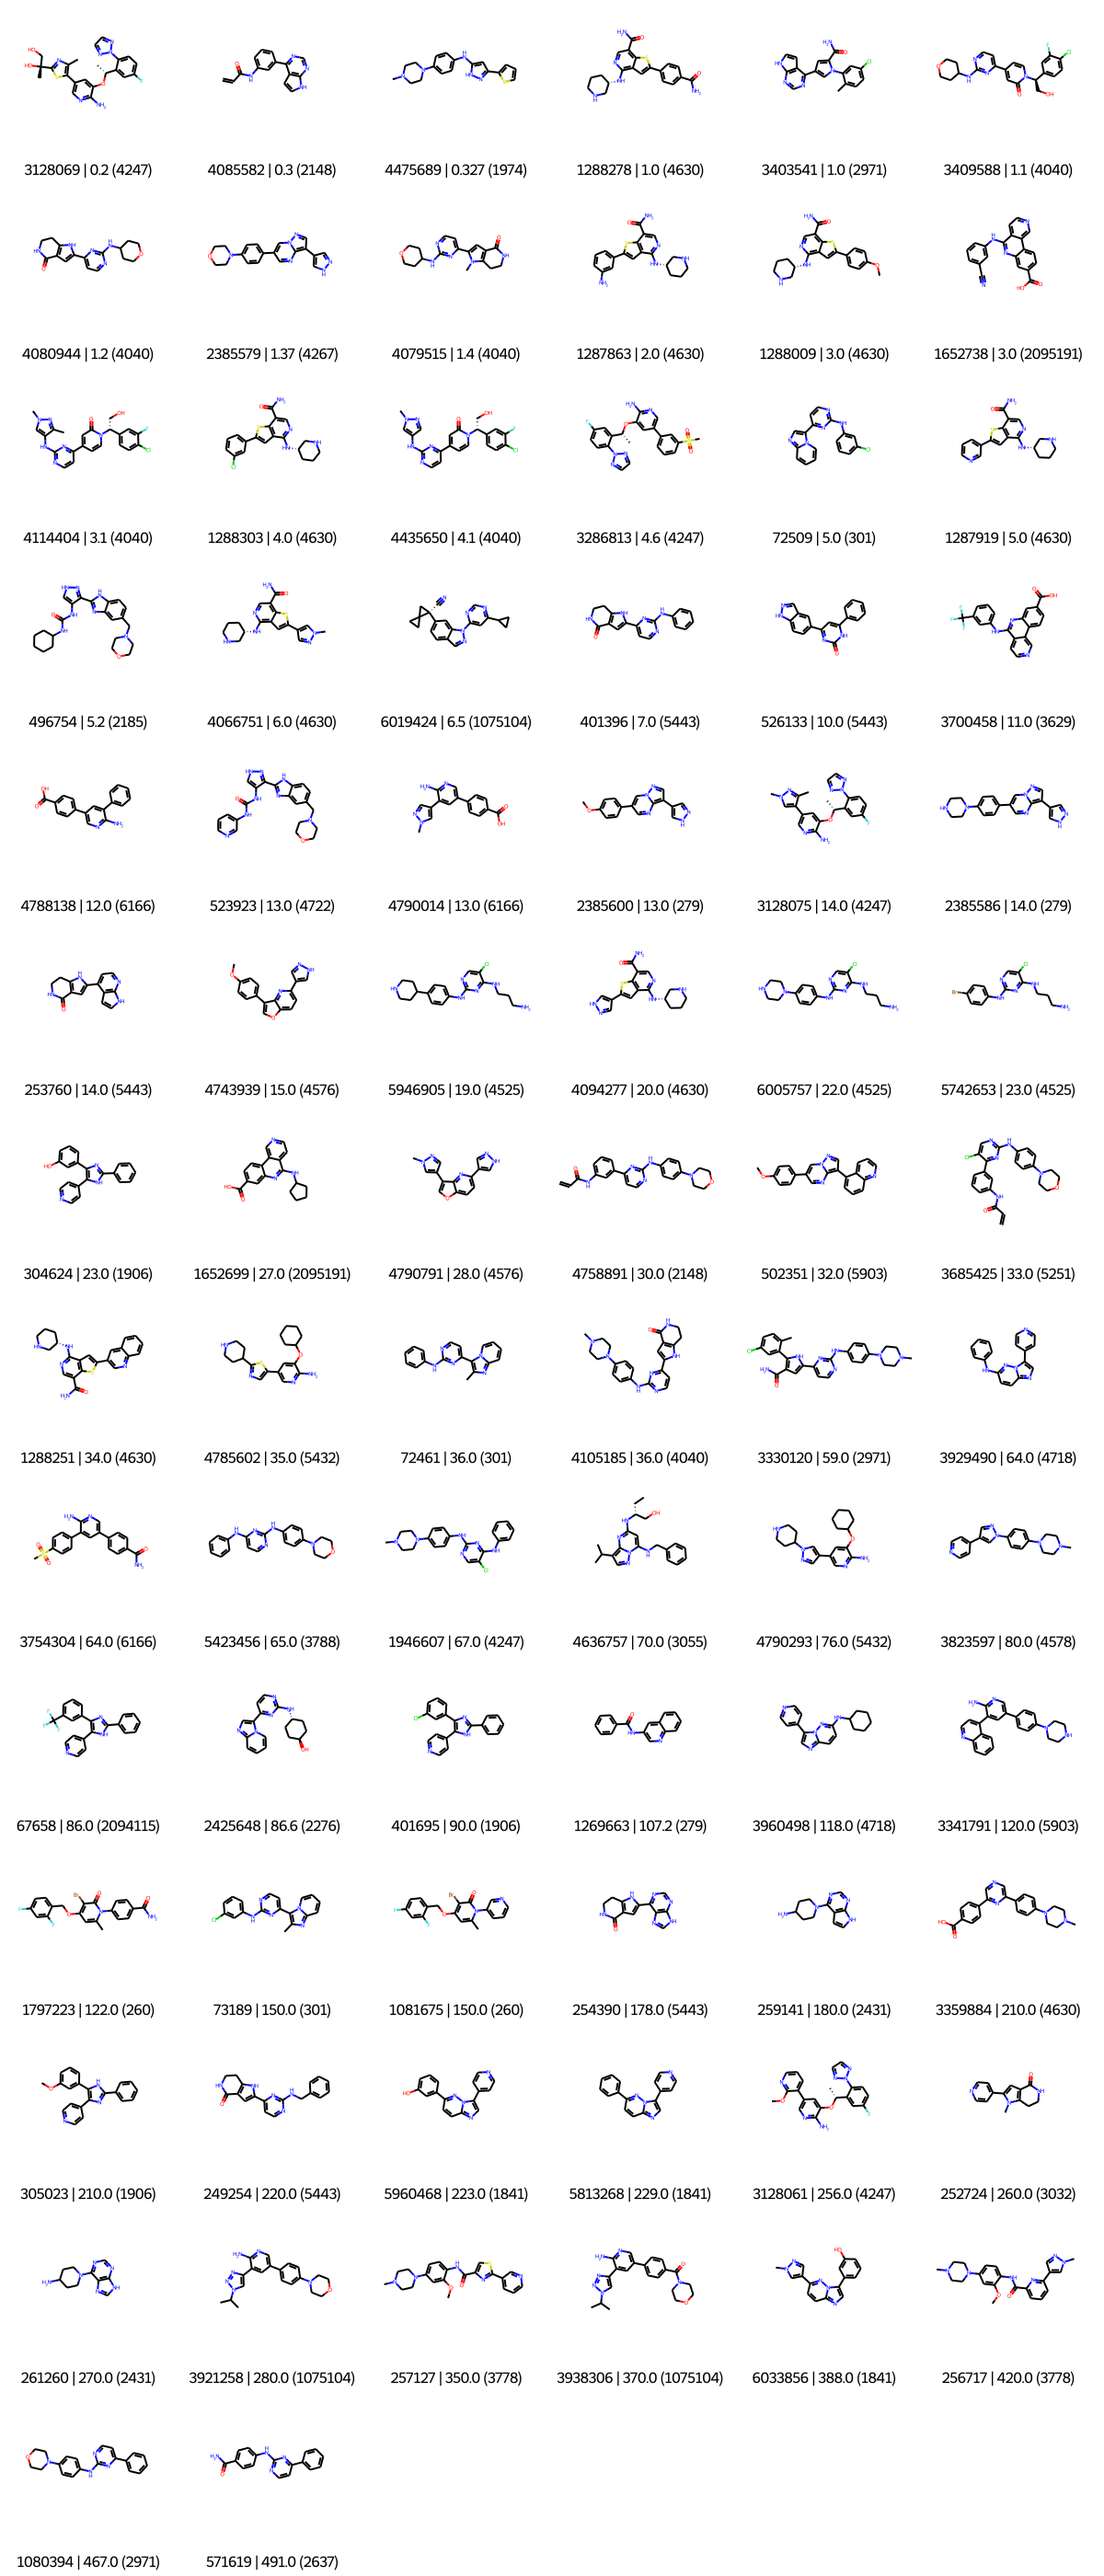

In [77]:
print(f'Molecule ChEMBL ID (add "CHEMBL" at front) | minimum activity value (target ChEMBL ID of tested target (add "CHEMBL" at front))')

image = Draw.MolsToGridImage(
    mols=molecules_with_kinase_targets.smiles.apply(lambda x: Chem.MolFromSmiles(x)).tolist(),
    legends=molecules_with_kinase_targets.apply(
        lambda x: f'{x.molecule_chembl_id[6:]} | {np.min(x.standard_value)} ({x.target_chembl_id[np.argmin(x.standard_value)][6:]})', 
        axis=1
    ).to_list(),
    molsPerRow=6,
    maxMols=100,
    returnPNG=False
)
image

Save this figure for publication's supporting information.

In [78]:
image.save("figures/combinatorial_library_active_kinase_targets.png")

Show activity distribution for molecules with kinase target(s) - plot only minimum activity per molecule (in case there are multiple kinase activities measured).

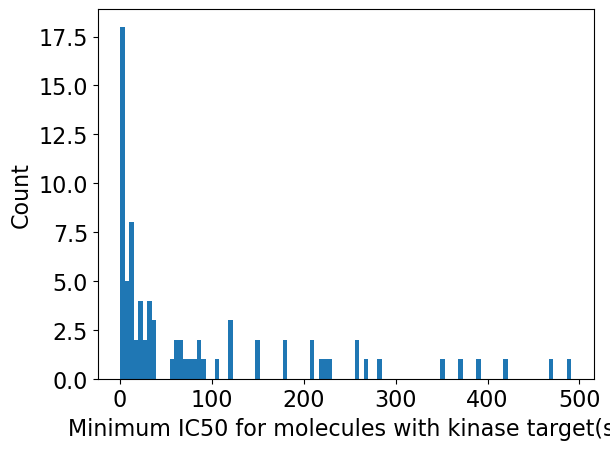

In [79]:
ax = molecules_with_kinase_targets.standard_value.apply(min).plot(kind='hist', bins=100, fontsize=16)
ax.set_xlabel('Minimum IC50 for molecules with kinase target(s)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.get_figure().savefig('figures/combinatorial_library_active_kinase_targets_activities.png', bbox_inches='tight', transparent=True)

Text(0.5, 0, 'Number of targets per molecule')

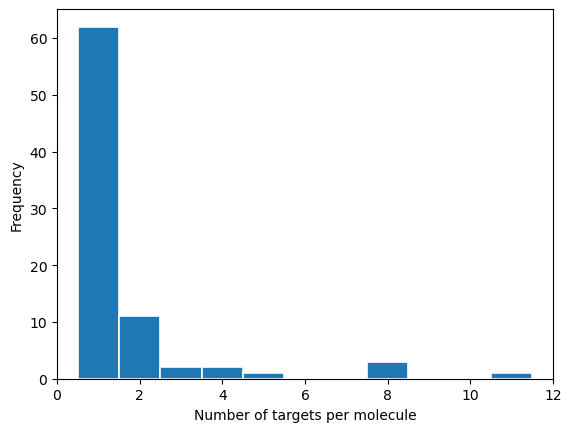

In [80]:
ax = n_active_targets_per_molecule.plot(
    kind='hist', 
    bins=np.arange(n_active_targets_per_molecule.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_active_targets_per_molecule.max() + 1]
)
ax.set_xlabel('Number of targets per molecule')

#### Molecules with kinase target(s) with activity of <= 5 nM

In [81]:
activities_active_kinases_5nm = activities_active_kinases[
    activities_active_kinases.standard_value <= 5
]

In [82]:
print(f'Number of molecules with kinase target(s) and an activity of <= 5 nM: {activities_active_kinases_5nm.groupby("molecule_chembl_id").first().shape[0]}')

Number of molecules with kinase target(s) and an activity of <= 5 nM: 18


In [83]:
filtering = add_filtering_step(filtering, activities_active_kinases_5nm, 'Only molecule-kinase pairs with activity <= 5 nM')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,135,111,212,347
0,Remove non-nM activities,134,110,210,345
0,Only human entries,122,97,178,299
0,Get minimum IC50 per molecule-target pair,122,97,130,215
0,"Only ""active"" molecule-target pairs",82,61,82,138
0,Only molecule-kinase pairs,80,59,80,136
0,Only molecule-kinase pairs with activity <= 5 nM,18,18,21,27


#### Write molecules with active kinases (IC50 <= 5nm) to `csv` file

In [84]:
activities_active_kinases_5nm_paper = activities_active_kinases_5nm[['molecule_chembl_id', 'target_pref_name', 'l4', 'assay_chembl_id', 'standard_value']].copy()
activities_active_kinases_5nm_paper['l4'] = activities_active_kinases_5nm_paper.apply(lambda x: x.l4.split()[0], axis=1)
activities_active_kinases_5nm_paper.sort_values(['molecule_chembl_id', 'standard_value'], inplace=True)
activities_active_kinases_5nm_paper = activities_active_kinases_5nm_paper.rename(
    columns={
        'molecule_chembl_id': 'Molecule ChEMBL ID', 
        'target_pref_name': 'Kinase name', 
        'l4': 'Kinase group', 
        'assay_chembl_id': 'Assay ChEMBL ID',
        'standard_value': 'IC50 [nM]'
    }
)
activities_active_kinases_5nm_paper.to_csv(HERE / '../../data/combinatorial_library/combinatorial_library_active_kinase_targets_nm.csv', index=None)

## Appendix: Compare exact with most similar ChEMBL matches!

### Load highly similar ChEMBL molecules

Load highly similar ChEMBL molecules (similarity > 0.9).

In [85]:
chembl_highly_similar = pd.read_json(HERE / '../../data/combinatorial_library/chembl_highly_similar.json')
print(chembl_highly_similar.shape)
# NBVAL_CHECK_OUTPUT

(3783, 12)


In [86]:
chembl_highly_similar.head(2)

,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
0,"[[AP_12, GA_6], [AP_11, SE_3], [FP_6, AP_10]]","[AP_12, SE_86, GA_21, FP_37]",1,1,1,1,25,0,"[CHEMBL4071527, 0.91]",0,0,"InChI=1S/C19H16N6/c1-2-7-22-18-11-17(15-4-3-8-21-12-15)24-19-16(13-23-25(18)19)14-5-9-20-10-6-14/h2-6,8-13,22H,1,7H2"
1,"[[AP_12, GA_3], [FP_6, AP_10], [SE_7, AP_11]]","[AP_12, FP_121, SE_26, GA_84]",1,1,1,1,26,0,"[CHEMBL249531, 0.98]",0,0,"InChI=1S/C21H19N5/c1-2-7-18-15-24-26-20(23-14-16-8-6-11-22-13-16)12-19(25-21(18)26)17-9-4-3-5-10-17/h2-6,8-13,15,23H,1,7,14H2"


Get recombined ligands with similarity of 1.0 to at least one ChEMBL ligand.

In [87]:
chembl_highly_similar_1 = chembl_highly_similar[chembl_highly_similar.apply(lambda x: x.chembl_most_similar[1] == 1.0, axis=1)]
print(chembl_highly_similar_1.shape)

(468, 12)


In [88]:
chembl_highly_similar_1.head(2)

,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
7,"[[AP_12, GA_3], [FP_6, AP_10], [SE_7, AP_11]]","[AP_12, FP_54, GA_12, SE_24]",1,1,1,1,26,1,"[CHEMBL4636757, 1.0]",0,0,"InChI=1S/C20H27N5O/c1-4-16(13-26)23-18-10-19(21-11-15-8-6-5-7-9-15)25-20(24-18)17(12-22-25)14(2)3/h5-10,12,14,16,21,26H,4,11,13H2,1-3H3,(H,23,24)/t16-/m1/s1"
100,"[[AP_12, GA_4], [SE_7, AP_11], [FP_6, AP_10]]","[AP_12, GA_39, SE_26, FP_121]",1,1,1,1,27,1,"[CHEMBL399087, 1.0]",0,0,"InChI=1S/C19H14F3N5/c20-19(21,22)15-12-25-27-17(24-11-13-5-4-8-23-10-13)9-16(26-18(15)27)14-6-2-1-3-7-14/h1-10,12,24H,11H2"


### Sanity check: Exact matches have similarity of 1.0?

In [89]:
print(f'How many exact matches do NOT have a similarity of 1.0? {exact_matches[exact_matches.chembl_most_similar.apply(lambda x: x[1] != 1.0)].shape[0]}')
# NBVAL_CHECK_OUTPUT

How many exact matches do NOT have a similarity of 1.0? 0


Great! Moving on.

### Check recombined ligands with similarity of 1.0 that are no exact matches

Get all recombined ligands that have similarity of 1.0 in ChEMBL but are no exact matches.

In [90]:
ligands_no_exact_similarity_1 = chembl_highly_similar_1[~chembl_highly_similar_1.inchi.isin(exact_matches.inchi)]
ligands_no_exact_similarity_1.reset_index(drop=True, inplace=True)
ligands_no_exact_similarity_1.shape
# NBVAL_CHECK_OUTPUT

(182, 12)

For each recombined ligand, draw recombined ligands and the ChEMBL ligand that has a similarity of 1.0 (**calculate similarity here again!**).

In [91]:
mols = []
legends = []
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

for index, recombined_ligand in ligands_no_exact_similarity_1.iterrows():
    
    # Get ROMol for recombined ligand
    recomb_mol = Chem.MolFromInchi(recombined_ligand.inchi)
    # Get ROMol for ChEMBL ligand
    chembl_mol = Chem.MolFromInchi(chembl[chembl.chembl_id == recombined_ligand.chembl_most_similar[0]].inchi.iloc[0])
    
    # Calculate similarity again!
    recomb_fp = rdkit_gen.GetFingerprint(recomb_mol)
    chembl_fp = rdkit_gen.GetFingerprint(chembl_mol)
    similarity = DataStructs.TanimotoSimilarity(recomb_fp, chembl_fp)
    
    # Check if fingerprints are different
    if recomb_fp.ToBitString() != chembl_fp.ToBitString():
        print(f'Ligand {index} has different fingerprints for recombined and ChEMBL ligand.')
    # Check if similarity is exactly 1!
    if similarity != 1.0:
        print(f'Ligand {index} has similarity != 1.0: {similarity}')
    
    mols.extend([recomb_mol, chembl_mol])
    legends.extend([f'{index}: Recombined ligand', f'{index}: ChEMBL ligand ({round(similarity, 6)})'])
    
# NBVAL_CHECK_OUTPUT

Ligand 28 has different fingerprints for recombined and ChEMBL ligand.
Ligand 28 has similarity != 1.0: 0.9952830188679245
Ligand 31 has different fingerprints for recombined and ChEMBL ligand.
Ligand 31 has similarity != 1.0: 0.9970326409495549
Ligand 152 has different fingerprints for recombined and ChEMBL ligand.
Ligand 152 has similarity != 1.0: 0.9975903614457832
Ligand 164 has different fingerprints for recombined and ChEMBL ligand.
Ligand 164 has similarity != 1.0: 0.9964539007092199



Show 3 recombined-ChEMBL ligand pairs per row


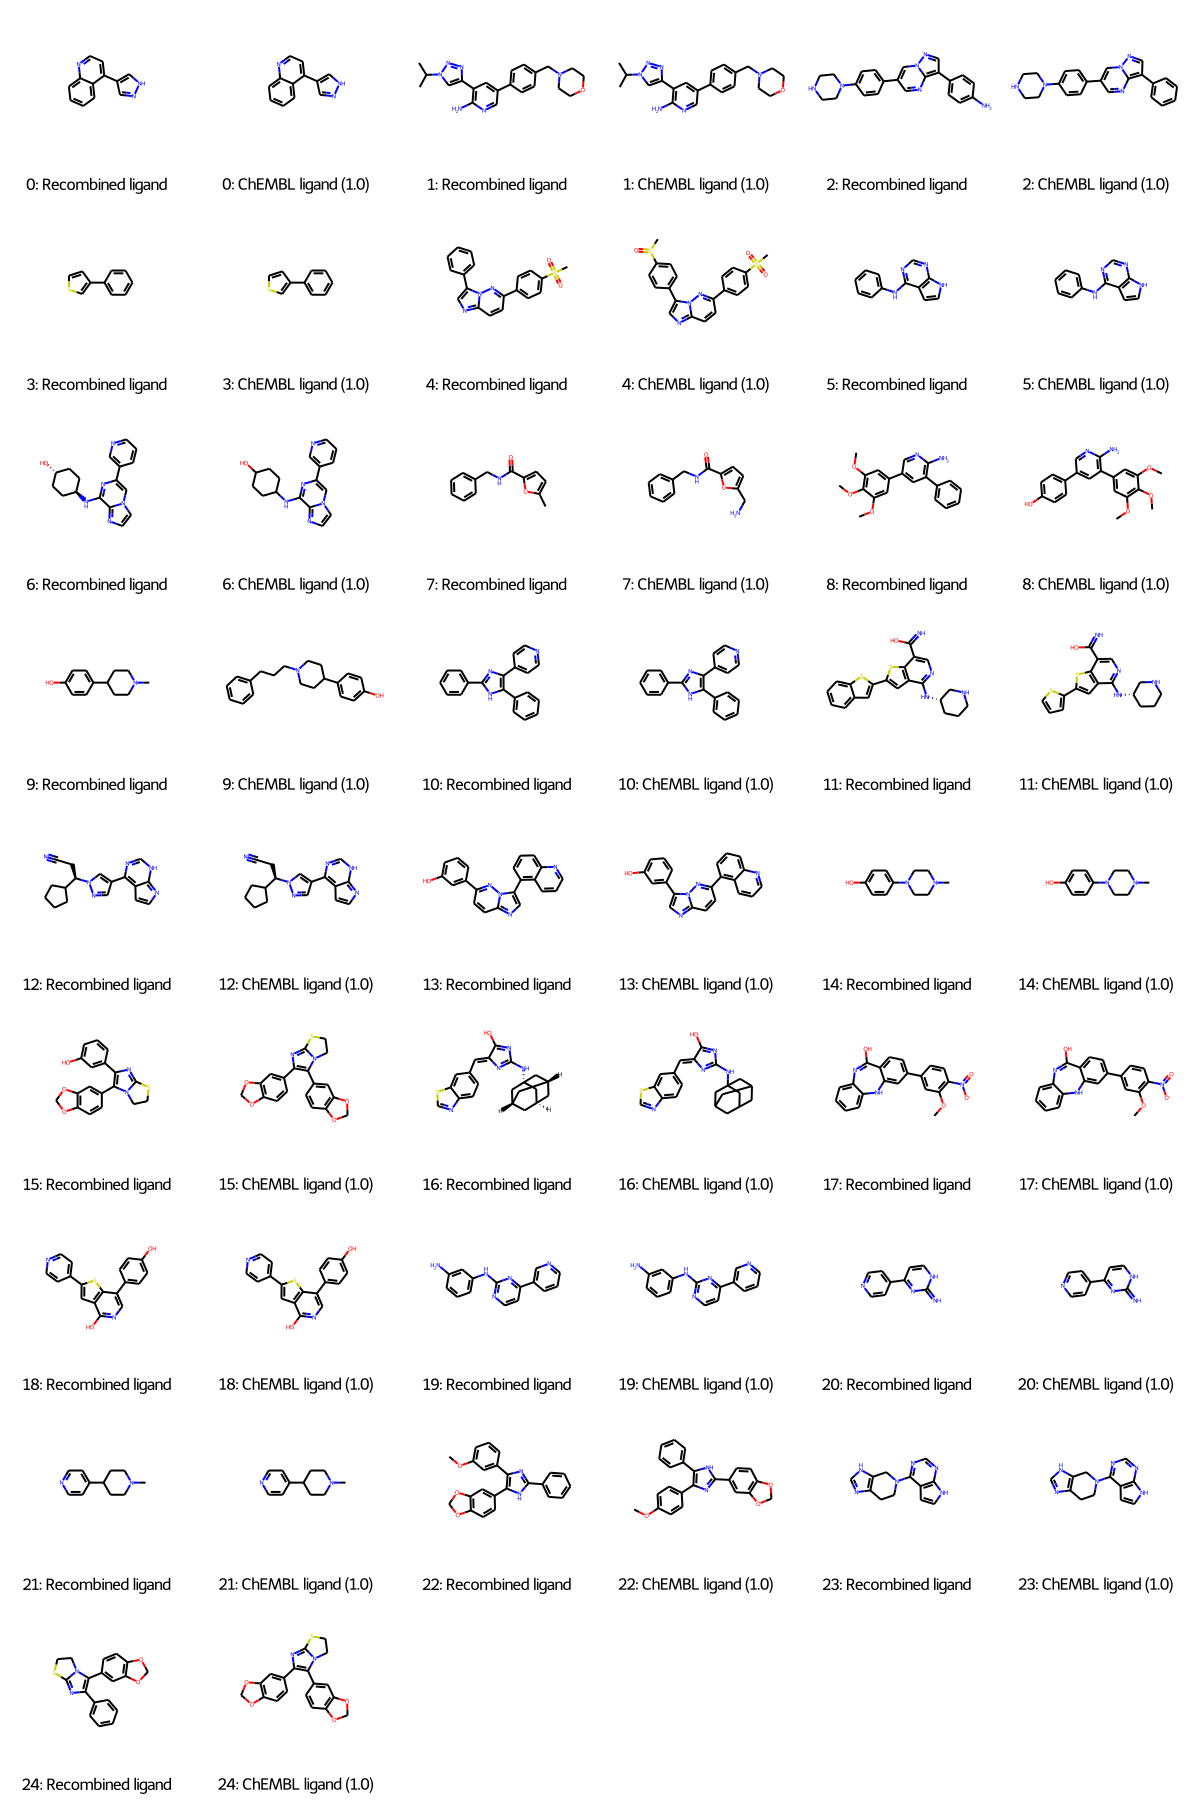

In [92]:
print(f'\nShow 3 recombined-ChEMBL ligand pairs per row')
Draw.MolsToGridImage(
    mols=mols[:50],
    legends=legends,
    molsPerRow=6
)

As we see here, some ligands show a similarity of 1.0 although they are not identical. Mostly these ligands show repetitive chemical moieties that are not encoded unambiguously in the fingerprint!

Hence, in order to assess identical ligands between the recombined ligands and ChEMBL, exact matches using InChI comparison is the safer choice!